# Soft Actor Critic (SAC) Algorithm

In [1]:
from source import *
import tensorflow as tf
from tensorflow.keras import layers

### Make an environment |'Pendulum-v1'|

State shape: (3,)
Action shape: (1,)


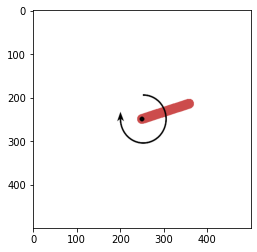

In [2]:
env_name = 'Pendulum-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

### Build Policy Agent (Actor)

In [3]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20
EPS = 1e-8

def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

def apply_squashing_func(mu, pi, logp_pi):
    # Adjustment to log prob
    # NOTE: This formula is a little bit magic. To get an understanding of where it
    # comes from, check out the original SAC paper (arXiv 1801.01290) and look in
    # appendix C. This is a more numerically-stable equivalent to Eq 21.
    # Try deriving it yourself as a (very difficult) exercise. :)
    logp_pi -= tf.reduce_sum(2*(np.log(2) - pi - tf.nn.softplus(-2*pi)), axis=1)
    # Squash those unbounded actions!
    mu = tf.tanh(mu)
    pi = tf.tanh(pi)
    return mu, pi, logp_pi

class SquashedGaussianMLPActor(tf.keras.Model):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        self.fc1 = layers.Dense(256, activation="relu")
        self.fc2 = layers.Dense(256, activation="relu")
        self.mu_layer = layers.Dense(act_dim)
        self.log_std_layer = layers.Dense(act_dim)
        self.act_limit = act_limit
    
    def call(self, s):
        x = self.fc1(s)
        x = self.fc2(x)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        log_std = tf.clip_by_value(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = tf.exp(log_std)
        pi = mu + tf.random.normal(tf.shape(mu)) * std
        logp_pi = gaussian_likelihood(pi, mu, log_std)
        mu, pi, logp_pi = apply_squashing_func(mu, pi, logp_pi)
        mu *= self.act_limit
        pi *= self.act_limit
        return mu, pi, logp_pi

### Build Q-Network (Critic)

In [4]:
class MLPQFunction(tf.keras.Model):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        self.fc1 = layers.Dense(256, activation="relu")
        self.fc2 = layers.Dense(256, activation="relu")
        self.Q = layers.Dense(1)
    
    def call(self, s, a):
        x = tf.concat([s,a], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.Q(x)
        return tf.squeeze(q, -1) 

### Combine Actor and Critic models into a single model

In [5]:
class MLPActorCritic(tf.keras.Model):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = SquashedGaussianMLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state, deterministic=False):
            mu, pi, _ = self.policy(state)
            if deterministic:
                return mu.numpy()
            else:
                return pi.numpy()
    
    def get_action(self, state, deterministic=False):
        return self.act(state.reshape(1,-1).astype("float32")).reshape(-1)

### Training Hyperparameters

In [6]:
steps_per_epoch = 4000
epochs = 5
replay_size = 1e6
batch_size = 64
update_every = 50
start_steps = 1e4

### Experience Buffer

In [7]:
replay_buffer = ReplayBuffer(replay_size)

### Make the environments

In [8]:
env = make_env(env_name)
test_env = make_env(env_name)

### Make an agent

In [9]:
agent = MLPActorCritic(env.observation_space, env.action_space)

2022-08-24 09:15:47.066206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
agent = sac(env, test_env, agent, steps_per_epoch=steps_per_epoch, epochs=epochs, replay_size=replay_size,
            batch_size=batch_size, update_every=update_every, start_steps=start_steps)

INFO:tensorflow:Assets written to: ram://8144d11a-ac01-4a25-9c93-a47d9b011aac/assets
INFO:tensorflow:Assets written to: ram://38bb1f96-2669-4ea5-9b4b-64413c9f0a0f/assets
INFO:tensorflow:Assets written to: ram://3e1e13b3-4a5f-4561-8242-c51fd8d32384/assets
End of epoch: 1, Training Average Reward: -6229, Training Average Length: 1000
End of epoch: 1, Test Average Reward: -142, Test Average Length: 1000
End of epoch: 2, Training Average Reward: -5532, Training Average Length: 1000
End of epoch: 2, Test Average Reward: -168, Test Average Length: 1000
End of epoch: 3, Training Average Reward: -3071, Training Average Length: 1000
End of epoch: 3, Test Average Reward: -178, Test Average Length: 1000
End of epoch: 4, Training Average Reward: -160, Training Average Length: 1000
End of epoch: 4, Test Average Reward: -178, Test Average Length: 1000
End of epoch: 5, Training Average Reward: -131, Training Average Length: 1000
End of epoch: 5, Test Average Reward: -214, Test Average Length: 1000


### Generate Anime of learned (trained) Policy Agent

In [11]:
# Animate learned policy
save_dir='./videos/sac/pendulum'
env = gym.make(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Reward: -237.87031699995424
